In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

/tmp/ipykernel_797504/3849965675.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', N + 1)  # N malware families + 1 benign


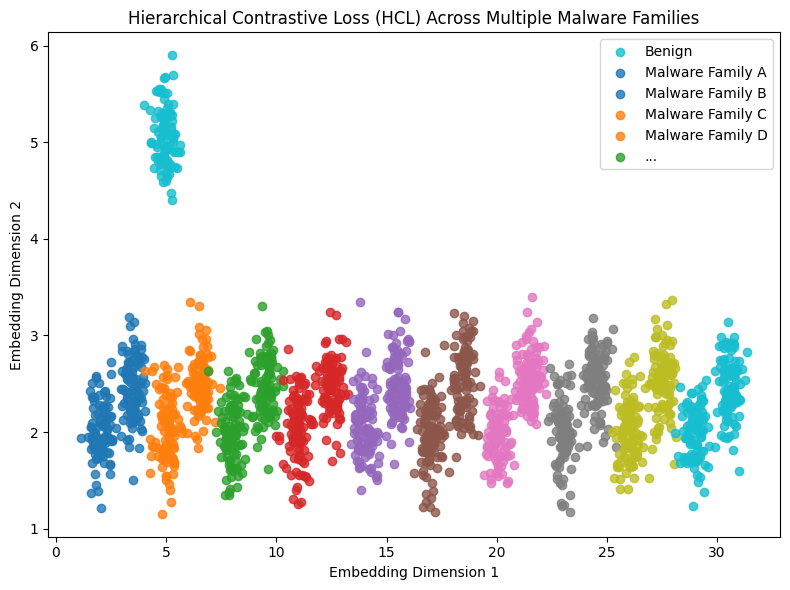

In [ ]:
N = 20
samples_per_class = 100
benign_center = np.array([5, 5])
malware_centers = [np.array([2 + i*1.5, 2 + (i % 2) * 0.5]) for i in range(N)]
colors = plt.cm.get_cmap('tab10', N + 1)  # N malware families + 1 benign

data = []
labels = []

for i in range(N):
    cluster = np.random.normal(loc=malware_centers[i], scale=0.3, size=(samples_per_class, 2))
    data.append(cluster)
    labels.extend([f"Malware Family {chr(65+i)}"] * samples_per_class)

benign = np.random.normal(loc=benign_center, scale=0.3, size=(samples_per_class, 2))
data.append(benign)
labels.extend(["Benign"] * samples_per_class)

plt.figure(figsize=(8, 6))
for i, cluster in enumerate(data):
    label = labels[i * samples_per_class]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=label, alpha=0.8, color=colors(i))

plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("Hierarchical Contrastive Loss (HCL) Across Multiple Malware Families")
plt.grid(True)
plt.tight_layout()

# legend filtering (before show)
handles, labels = plt.gca().get_legend_handles_labels()
max_families = 5
labels[max_families - 1] = "..."
filtered = []
added_labels = set()

for h, l in zip(handles, labels):
    if l == "Benign":
        filtered.insert(0, (h, l)) 
    elif len(added_labels) < max_families and l not in added_labels:
        filtered.append((h, l))
        added_labels.add(l)

if filtered: 
    filtered_handles, filtered_labels = zip(*filtered)
    plt.legend(filtered_handles, filtered_labels, loc='upper right')

plt.grid(False)

plt.show()

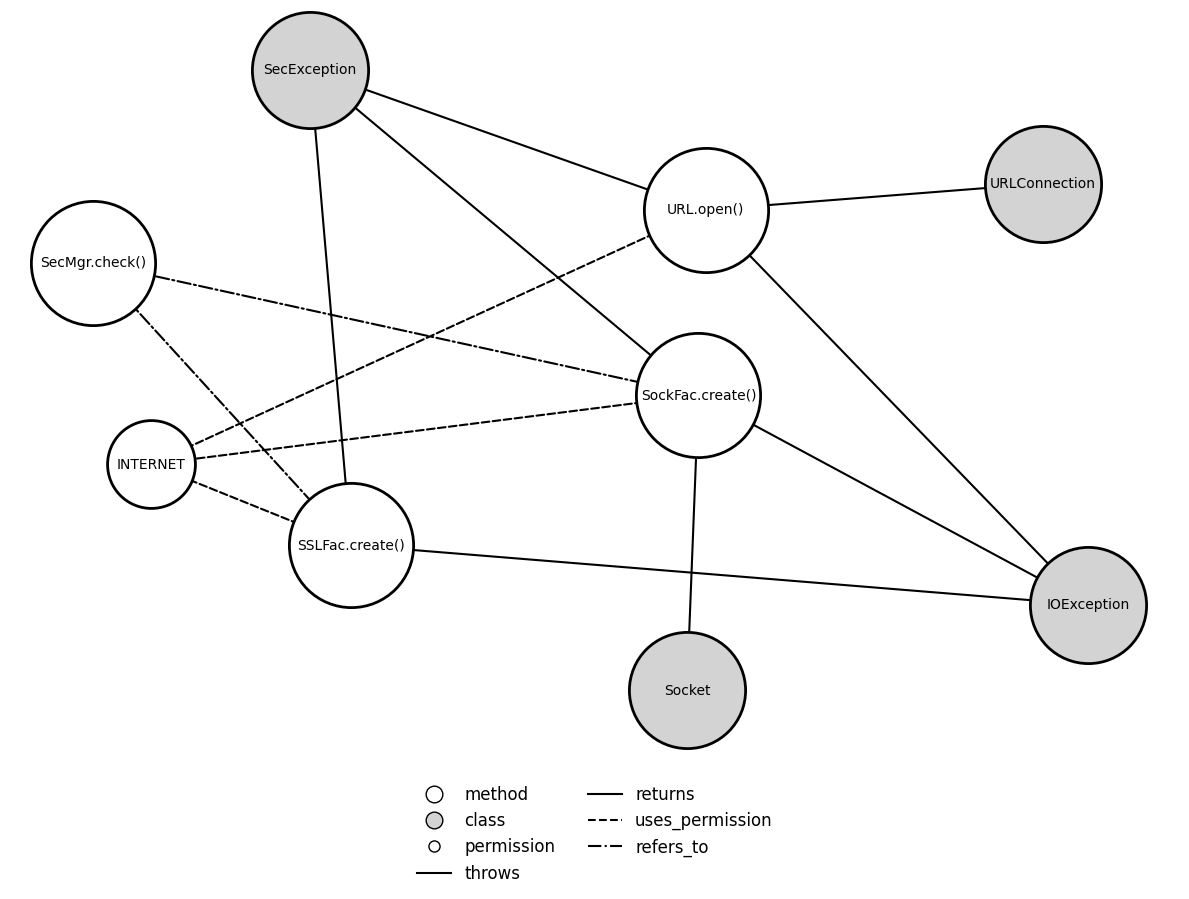

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

G = nx.DiGraph()

nodes = {
    "java.net.URL;\nopenConnection()": "method",
    "javax.net.SocketFactory;\ncreateSocket()": "method",
    "javax.net.ssl.SSLSocketFactory;\ncreateSocket()": "method",
    "java.lang.SecurityManager;\ncheckConnect()": "method",
    "java.net.URLConnection": "class",
    "java.lang.SecurityException": "class",
    "java.io.IOException": "class",
    "java.net.Socket": "class",
    "android.permission.INTERNET": "permission"
}

short_labels = {
    "java.net.URL;\nopenConnection()": "URL.open()",
    "javax.net.SocketFactory;\ncreateSocket()": "SockFac.create()",
    "javax.net.ssl.SSLSocketFactory;\ncreateSocket()": "SSLFac.create()",
    "java.lang.SecurityManager;\ncheckConnect()": "SecMgr.check()",
    "java.net.URLConnection": "URLConnection",
    "java.lang.SecurityException": "SecException",
    "java.io.IOException": "IOException",
    "java.net.Socket": "Socket",
    "android.permission.INTERNET": "INTERNET"
}

for node, ntype in nodes.items():
    G.add_node(node, ntype=ntype)

edges = [
    ("java.net.URL;\nopenConnection()", "java.io.IOException", "throws"),
    ("java.net.URL;\nopenConnection()", "java.lang.SecurityException", "throws"),
    ("javax.net.SocketFactory;\ncreateSocket()", "java.io.IOException", "throws"),
    ("javax.net.SocketFactory;\ncreateSocket()", "java.lang.SecurityException", "throws"),
    ("javax.net.ssl.SSLSocketFactory;\ncreateSocket()", "java.io.IOException", "throws"),
    ("javax.net.ssl.SSLSocketFactory;\ncreateSocket()", "java.lang.SecurityException", "throws"),
    ("java.net.URL;\nopenConnection()", "java.net.URLConnection", "returns"),
    ("javax.net.SocketFactory;\ncreateSocket()", "java.net.Socket", "returns"),
    ("java.net.URL;\nopenConnection()", "android.permission.INTERNET", "uses_permission"),
    ("javax.net.SocketFactory;\ncreateSocket()", "android.permission.INTERNET", "uses_permission"),
    ("javax.net.ssl.SSLSocketFactory;\ncreateSocket()", "android.permission.INTERNET", "uses_permission"),
    ("javax.net.SocketFactory;\ncreateSocket()", "java.lang.SecurityManager;\ncheckConnect()", "refers_to"),
    ("javax.net.ssl.SSLSocketFactory;\ncreateSocket()", "java.lang.SecurityManager;\ncheckConnect()", "refers_to")
]

G.add_edges_from([(u, v, {"etype": et}) for u, v, et in edges])

pos = nx.spring_layout(G, seed=42, k=2)

node_types = {
    "method": {"color": "white", "size": 8000},
    "class": {"color": "lightgray", "size": 7000},
    "permission": {"color": "white", "size": 4000}
}

plt.figure(figsize=(12, 9))

for ntype, props in node_types.items():
    nodelist = [n for n in G.nodes if G.nodes[n]["ntype"] == ntype]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_color=props["color"],
        edgecolors="black",
        node_size=props["size"],
        linewidths=2
    )

edge_styles = {
    "throws": ("solid", 1.5),
    "returns": ("solid", 1.5),
    "uses_permission": ("dashed", 1.5),
    "refers_to": ("dashdot", 1.5)
}

for etype, (style, width) in edge_styles.items():
    edgelist = [(u, v) for u, v, d in G.edges(data=True) if d["etype"] == etype]
    nx.draw_networkx_edges(G, pos, edgelist=edgelist, style=style, width=width, arrows=True)

nx.draw_networkx_labels(G, pos, labels=short_labels, font_size=10)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='method',
           markerfacecolor='white', markeredgecolor='black', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='class',
           markerfacecolor='lightgray', markeredgecolor='black', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='permission',
           markerfacecolor='white', markeredgecolor='black', markersize=8),
    Line2D([0], [0], color='black', lw=1.5, linestyle='solid', label='throws'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='solid', label='returns'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='dashed', label='uses_permission'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='dashdot', label='refers_to')
]

plt.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.20),
    ncol=2,
    frameon=False,
    fontsize=12 
)
plt.axis('off')
plt.tight_layout()
plt.show()